# Multilinear Regression

## In this Lesson
* Data Exploration
* Simple Linear Regression
* Coefficients
* Multilinear Regression
* One-Hot Encoding

_N.B. Multilinear Regression is covered in my [main regression lession](https://github.com/Jack-Lawton/python-resources/blob/main/lessons/Regression.ipynb), but this represents a deeper dive on multilinear regression specifically._


# Data

For this lesson, we will be using London bike hire data [sourced from Kaggle](https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset). For convenience, I have included the data in this Git repository.

First let's load in the data with Python.

In [1]:

# Pandas to read the data
import pandas as pd
# Display function to view data
from IPython.display import display

# Read excel
df = pd.read_csv("../data/london_cycle_hire.csv")

# Display
display(df)


,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


As you can see, the data contains the count of total cycles hired for a range of days between 2015 and 2017, combined with weather and other contextual information, such as holidays and weekends.

For simplicity, let's say we only want to model behaviour over the weekend and reduce our data accordingly.


## Solution

In [35]:

weekend_data = df[df["is_weekend"] == 1]

display(weekend_data)


,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17361,2017-01-01 19:00:00,136,5.0,2.0,93.0,15.0,7.0,0.0,1.0,3.0
17362,2017-01-01 20:00:00,116,5.0,2.0,93.0,14.0,7.0,0.0,1.0,3.0
17363,2017-01-01 21:00:00,110,5.0,2.0,93.0,14.0,26.0,0.0,1.0,3.0
17364,2017-01-01 22:00:00,119,5.0,2.0,93.0,12.0,3.0,0.0,1.0,3.0


It is also good practice for machine learning problems to make a test/train split in the data, say train on the first 70% and test on the remaining 30%.

## Solution

In [3]:

split_point = int(len(weekend_data)*0.7)
train = weekend_data[:split_point]
test = weekend_data[split_point:]


Note, while there are multiple ways to complete a train/test split, for time series data, it makes the most sense to validate that we can predict the future from the past, so splitting the data in-order like this is a good idea.


# Exploration

When producing a Machine Learning model, it makes sense to first visualise our data and validate assumptions around which features will be useful.

My first hypothesis, is that temperature (t1) is a good indicator for hire count (cnt), and we should observe a correlation. Let's plot temperature against count to check this.


## Solution

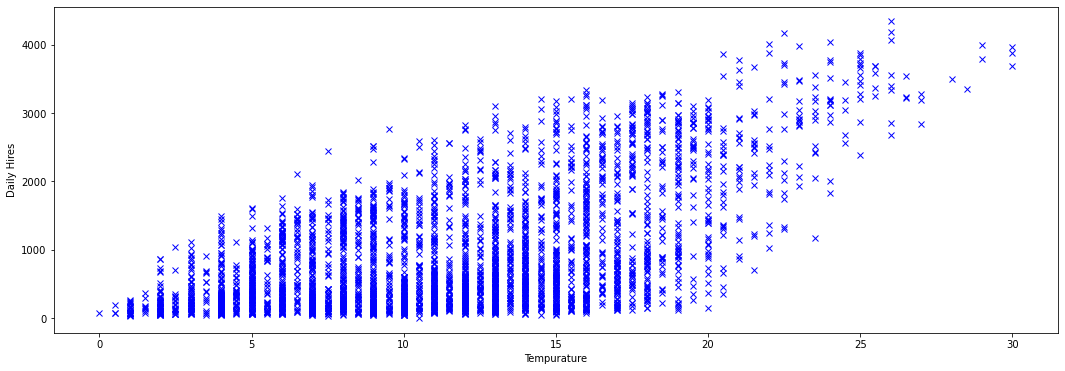

In [5]:

# Import matplotlib
from matplotlib import pyplot as plt

# Set up Axis (only required for notebooks envronments to make the plot larger)
fig, ax = plt.subplots(figsize=(18, 6))

# Plot our training data
plt.plot(train["t1"], train["cnt"], "bx")

# Add axis labels
plt.xlabel("Tempurature")
plt.ylabel("Daily Hires")

plt.show()


While the correlation could be stronger, there is a clear link between higher temperatures and more cycle hires, this should be a good feature to model.

# Simple Linear Model

At this point, we should be able to produce and assess the accuracy of a linear regression model using temperature only to predict daily hires.

## Solution

In [6]:

# Import linear rgression model
from sklearn.linear_model import LinearRegression
# Import r2 score to assess accuracy
from sklearn.metrics import r2_score

# Define model object
temp_model = LinearRegression()

# Fit model
temp_model.fit(train[["t1"]], train["cnt"])

# Predict hire counts
temp_predictions = temp_model.predict(test[["t1"]])

# Test model using r2
print("r2 score:")
print(r2_score(test["cnt"], temp_predictions))


r2 score:
0.3230448863186972


An r2 score of 0.3 isn't fantastic, but does demonstrate some predictive value in the model.

We can also demonstrate the model accuracy through visualisation, such as a line of fit:

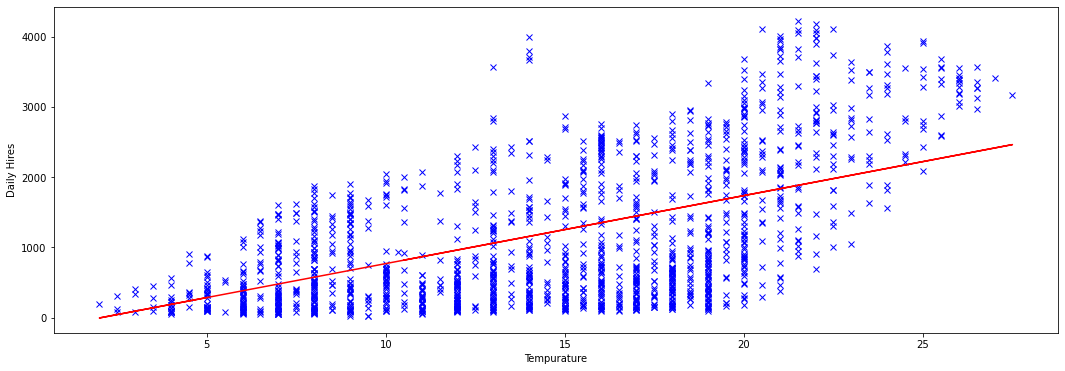

In [7]:

# Set up Axis (only required for notebooks envronments to make the plot larger)
fig, ax = plt.subplots(figsize=(18, 6))

# Plot our test data
plt.plot(test["t1"], test["cnt"], "bx")
# Plot our predicted values
plt.plot(test["t1"], temp_predictions, "r-")

# Add axis labels
plt.xlabel("Tempurature")
plt.ylabel("Daily Hires")

plt.show()



Or, plot predicted against actual, which will be more useful when we get to multilinear regression.


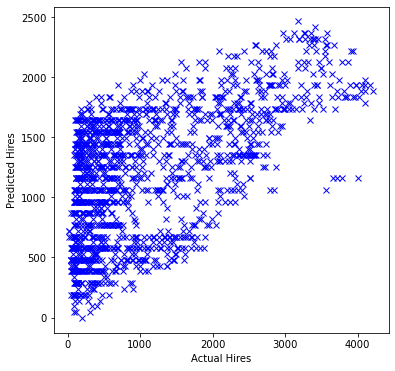

In [8]:

# Set up Axis (only required for notebooks envronments to make the plot larger)
fig, ax = plt.subplots(figsize=(6, 6))

# Plot our data
plt.plot(test["cnt"], temp_predictions, "bx")

# Add axis labels
plt.xlabel("Actual Hires")
plt.ylabel("Predicted Hires")

plt.show()

Ideally, this should be as close to a straight line as possible, with actuals corresponding directly to predicted.

## Other Variables

Of course, temperature is not the only data point available to us, we also have (for example) humidity, `hum`.

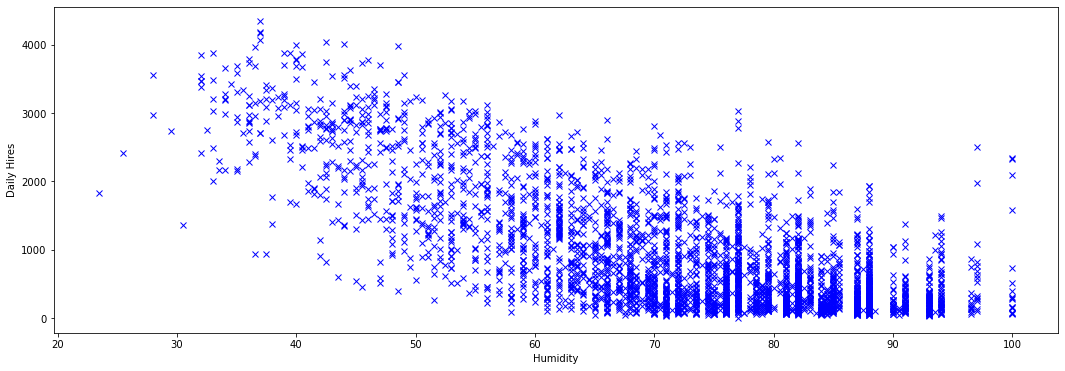

In [9]:

# Set up Axis (only required for notebooks envronments to make the plot larger)
fig, ax = plt.subplots(figsize=(18, 6))

# Plot Humidity
plt.plot(train["hum"], train["cnt"], "bx")

# Add axis labels
plt.xlabel("Humidity")
plt.ylabel("Daily Hires")

plt.show()


As you can see, humidity correlates negatively with cycle hires, and we can use this to build a predictive model also:

In [10]:

# Define model object
humidity_model = LinearRegression()

# Fit model
humidity_model.fit(train[["hum"]], train["cnt"])

# Predict hire counts
humidity_predictions = humidity_model.predict(test[["hum"]])

# Test model using r2
print("r2 score:")
print(r2_score(test["cnt"], humidity_predictions))


r2 score:
0.40191454400550797


As you can see, an r2 score of 0.4 means humidity is a better predictor than temperature. But can we do even better?

# Multilinear Models

Better than just using temperature or humidity on their own, we can leverage the predictive power of both by building a model which uses both.

## Solution

In [11]:

# Define model object
dual_model = LinearRegression()

# Fit model
dual_model.fit(train[["t1", "hum"]], train["cnt"])

# Predict hire counts
dual_predictions = dual_model.predict(test[["t1", "hum"]])

# Test model using r2
print("r2 score:")
print(r2_score(test["cnt"], dual_predictions))

r2 score:
0.5158638858001245


An r2 score 0f 0.5 demonstrates that using both temperature and humidity produces a model more accurate than using either alone.

We can also plot predicted against actuals to demonstrate this visually.

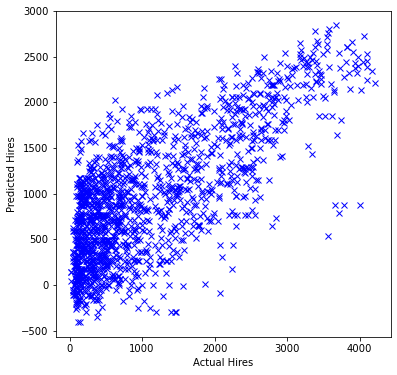

In [12]:

# Set up Axis (only required for notebooks envronments to make the plot larger)
fig, ax = plt.subplots(figsize=(6, 6))

# Plot our data
plt.plot(test["cnt"], dual_predictions, "bx")

# Add axis labels
plt.xlabel("Actual Hires")
plt.ylabel("Predicted Hires")

plt.show()

## How Does it Work?

Recall from fundamentals of [linear regression](https://github.com/Jack-Lawton/python-resources/blob/main/lessons/Regression.ipynb), to produce a linear fit, we must optimise the variables `m` (the gradient) and `c` (the intercept) in the equation for a straight line, in order to minimise the residuals and hence have the most predictive power. Where a straight line has the equation,

$y = mx + c$

When we do multilinear regression, the equation is similar, but we have multiple independent variables, while above we only have `x`. We would write this:

$y = c_0 + c_1x_1 + c_2x_2 + ... + c_nx_n$

Here $c_0$ is the intercept, but we have multiple independent variables, $x_1$ to $x_n$, each with its own coefficient, $c_1$ to $c_n$, which must all be optimised.

In the above solution, all of that optimisation is happening behind the scenes in the Sci-Kit Learn model, and consulting [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), we can actually pull out the values of those coefficients:


In [14]:

print(dual_model.coef_)


[ 52.7534044  -34.94323501]


And the intercept,

In [15]:

print(dual_model.intercept_)


2826.1915097957353


Meaning, we now know the equation this model uses to predict cycle hires:

$\text{predicted hires} = 2826 + 53\times \text{t1} - 35\times \text{hum}$

Feel free to manually check this.


# One-Hot Encoding

Temperature and humidity can only get us so far, also available in the data set is a code for weather. Consulting [Kaggle](https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset), we can see it is a lookup for weather type:

In [16]:

weather_lookup = {
    1: "Clear",
    2: "Scattered Clouds",
    3: "Broken Clouds",
    4: "Cloudy",
    7: "Rain",
    10: "Thunderstorm",
    26: "Snow",
    94: "Freezing Fog"
}



Let's try adding this weather feature to our model.


In [17]:

# Define model object
weather_model = LinearRegression()

# Fit model
weather_model.fit(train[["t1", "hum", "weather_code"]], train["cnt"])

# Predict hire counts
weather_predictions = weather_model.predict(test[["t1", "hum", "weather_code"]])

# Test model using r2
print("r2 score:")
print(r2_score(test["cnt"], weather_predictions))

r2 score:
0.5181653003025152



Curiously, the model is only marginally (0.003) better than the model without weather code. We might have thought that weather would significantly impact on cycle hire numbers, especially rainy weather.

## Discussion

Why might the model have not improved?


## Answer

The model is using the weather lookup as a linear component, multiplying a coefficient by the value. Like this, "Scattered Clouds" will have twice the impact of "Clear" weather, "Broken Clouds" would have three times the impact and "Cloudy" four, etc.

These fixed ratios may not accurately represent cycle hire behaviour in different weather types.

To fix this, we need to construct a model where each individual weather type has its own individual coefficient, i.e.

$\text{prediction} = \text{clear component} + \text{broken clouds component} + \text{cloudy component} + \text{...}$

To achieve this, we need to use a technique called One-Hot Encoding. We need to engineer features in our data which represent each individual weather type.


## Solution

In [30]:

# Copy train and test set for weather
train_weather = train.copy()
test_weather = test.copy()

# Initialise a list of features for conveinience
features = ["t1", "hum"]

# Look weather types lookup
for code, weather_type in weather_lookup.items():
    # Produce columns for each weather type
    train_weather[weather_type] = (train["weather_code"] == code)
    test_weather[weather_type] = (test["weather_code"] == code)
    # Add weather type to features
    features.append(weather_type)

# Display data to demonstrate new columns
display(test_weather[:5])


,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,Clear,Scattered Clouds,Broken Clouds,Cloudy,Rain,Thunderstorm,Snow,Freezing Fog
12201,2016-05-29 06:00:00,119,10.5,9.5,85.0,12.0,2.0,0.0,1.0,0.0,False,True,False,False,False,False,False,False
12202,2016-05-29 07:00:00,197,11.0,11.0,82.0,13.0,3.0,0.0,1.0,0.0,False,False,True,False,False,False,False,False
12203,2016-05-29 08:00:00,400,11.0,11.0,88.0,13.0,3.0,0.0,1.0,0.0,False,False,True,False,False,False,False,False
12204,2016-05-29 09:00:00,759,12.0,12.0,82.0,16.0,4.0,0.0,1.0,0.0,False,False,False,True,False,False,False,False
12205,2016-05-29 10:00:00,1301,13.0,13.0,79.5,18.0,4.0,0.0,1.0,0.0,False,False,False,True,False,False,False,False



Now we can build a predictive model with these new features


In [31]:

# Define model object
weather_oh_model = LinearRegression()

# Fit model
weather_oh_model.fit(train_weather[features], train_weather["cnt"])

# Predict hire counts
weather_oh_predictions = weather_oh_model.predict(test_weather[features])

# Test model using r2
print("r2 score:")
print(r2_score(test_weather["cnt"], weather_oh_predictions))


r2 score:
0.5362540742872166


Not a huge improvement on just temperature and humidity, but significantly more noticeable than without the one-hot encoding!

We can also pull out the coefficients and compare to our features to see which weather types have the greatest impact on cycle hire:

In [32]:

coefficients_frame = pd.DataFrame()

coefficients_frame["Feature"] = features
coefficients_frame["Coefficient"] = weather_oh_model.coef_

display(coefficients_frame)


,Feature,Coefficient
0,t1,51.783115
1,hum,-36.245056
2,Clear,-157.199829
3,Scattered Clouds,69.811438
4,Broken Clouds,87.970811
5,Cloudy,-14.171707
6,Rain,-33.692764
7,Thunderstorm,-81.478172
8,Snow,128.760222
9,Freezing Fog,0.000000



## Activity

Discuss the possible reasons for these coefficients.


# Recap

Today we have learnt:
* Approaches to exploring data
* How to build simple regression models with Sci-Kit Learn
* How to understand coefficients in regression models
* What is Multilinear regression
* One-Hot Encoding